For the final part of my series on Love Island via data analytics I am going to do create models that aim to predict the number of days an islander is expected to stay on the show, as well as which couple is going to win. We will use the data from series 4 as our training set and apply the models to the new data from series 5 to predict outcomes. For this analysis we are going to use a polynomial regression model of order 2, this is due to wanting sure we make sure that we incorporate the interaction effect between all the features we use. One over-arching point to not is that in Series 4 a number of islanders had the same name, given we are only using first names to identify islanders in each tweet this will cause some noise within our data. In every case I focus on the most relevant islander per name and this should matter too much aside from Jack Fincham and Jack Fowler who were both impactful on the series.

In [1]:
from loveisland.common.functions import Functions as F
from loveisland.common.constants import RESULTS_4, RESULTS_5

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import re
import pandas as pd
import os
import datetime as dt

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.options.mode.chained_assignment = None 

plt.style.use("bmh")

In [2]:
class Arguments():
    def __init__(self, season, bucket="../data/"):
        self.season = season
        self.bucket = bucket

### Predicting the Number of Days an Islander Lasts
For the first part of this analysis we are going try and determine if we can predict the number of days that an islander will last for. There are various ways that islanders are "dumped" from the show, these include being voted off by other islanders, being voted off by the public or by not being in a couple for example, given that the public has a relatively small part to play in the process (even when voting off the contestant the incumbent islanders usually have the final say), therefore the dataset we will be using to train the model is very incomplete. 

In [3]:
class AggAgg:
    def __init__(self, args):
        self.args = args
        self.df = pd.read_csv(
            os.path.join(args.bucket, "season_" + str(args.season), "agg_df.csv")
        )

    @staticmethod
    def date_to_n_lookup(df):
        n_list = list(range(1, df["dumped"].max() + 1))
        d_list = [(df["date"].min() + dt.timedelta(days=n)).date() for n in n_list]
        return pd.DataFrame.from_dict({"dumped": n_list, "dumped_d": d_list})

    def start_end(self):
        if self.args.season == 4:
            sd, ed = "2018-06-04", "2018-07-30"
        else:
            sd, ed = "2019-06-03", "2019-07-30"

        self.df = self.df[(sd <= self.df["date"]) & (self.df["date"] < ed)].reset_index(
            drop=True
        )
        return self

    def islander_agg(self):
        self.df["date"] = pd.to_datetime(self.df["date"])
        self.start_end()
        self.df = self.df.merge(self.date_to_n_lookup(self.df), on="dumped", how="left")
        self.df["dumped_d"] = pd.to_datetime(self.df["dumped_d"])
        self.df = self.df[
            (self.df["date"] <= self.df["dumped_d"]) | (self.df["dumped"] == 0)
        ].reset_index(drop=True)

        self.df = (
            self.df.groupby(["islander", "date"])
            .agg({"n_tweets": "sum", "score": "mean", "favs": "mean"})
            .reset_index()
        )
        self.df["n_tweets_perc"] = self.df.groupby("date")["n_tweets"].apply(
            lambda x: x * 100 / sum(x)
        )
        self.df = (
            self.df.groupby("islander")
            .agg({"n_tweets": "sum", "score": "mean", "n_tweets_perc": "mean", "favs": "mean"})
            .reset_index()
        )

        self.df = self.df.merge(
            F.get_islander_df(self.args.season), on="islander", how="left"
        )
        return self
    
    def create_dummy(self):
        self.df["male"] = np.where(self.df["sex"] == "male", 1, 0)
        return self

    def create_days(self):
        self.df["n_days"] = np.where(
            self.df["dumped"] == 0,
            59 - self.df["arrived"],
            self.df["dumped"] - self.df["arrived"],
        )
        self.df["n_days_perc"] = self.df["n_days"] / (59 - self.df["arrived"])
        return self
    
def normalize(df, ind_cols=["n_tweets_perc", "score"], dep_col="n_days_perc"):
    for col in ind_cols:
        df = df[df[col].notna()]
        df[col] = preprocessing.normalize([df[col]])[0]
    return df[df[dep_col].notna()]


def fit_mod(df, dep_col="n_days_perc", ind_cols=["n_tweets_perc", "score"]):      
    poly = preprocessing.PolynomialFeatures(degree=2)
    reg = linear_model.LinearRegression()
    reg.fit(poly.fit_transform(df[ind_cols]), df[dep_col])
    return reg, poly


def get_stats(df, reg, poly, dep_col="n_days_perc", ind_cols=["n_tweets_perc", "score"]):    
    print("\033[1mRegression outputs", "\033[0;0m")
    print("x0 = n_tweets_perc\nx1 = mean sentiment score\n")
    print("Intercept:", reg.intercept_, "\n") 

    for c in zip(poly.get_feature_names(), reg.coef_):
        if c[0] != '1':
            print("Coefficient for {}: {}".format(c[0], c[1])) 
            
    print("\nR^2 score:", reg.score(poly.fit_transform(df[ind_cols]), df[dep_col]))


def apply_mod(df, req, poly):
    df["pred"] = df.apply(
        lambda row:reg.predict(poly.fit_transform([[row["n_tweets_perc"], row["score"]]]))[0],
        axis=1)
    df["diff"] = df["n_days_perc"] - df["pred"]
    df["b_o_w"] = np.where(df["diff"] < 0, "worse", "better")
    return df


### Preprocessing 
1. Find mean sentiment score of all tweets about each islander per day, find the percentage of tweets per day that included a direct reference to each islander.
2. Filter to only include the days that the islander was in the villa (if an islander left and in reaction to their actions on the outside they may have got a lot of tweets etc, this isn't relevant for predicting something during their time in the villa).
3. Find the mean sentiment score per islander from the days they were in the villa and the mean percentage of tweets about them across all the days they were inside; we want to be "fair" to all islanders, if we simply took the percentage of tweets per all tweets we would be very biased towards islanders who have been their longer, so by taking the average per day, then the average of these, we normalize for islanders who have been on the show for different lengths of time.
4. Add some metadata to use downstream (age, sex etc)
5. Calculate the proportion of days an islander lasted out of the total number of days they could have stayed. If an islander entered on day 30 and lasted until day 60, then this is only half as many days as someone who entered on day 1 and lasted until day 60, however their available days is half as many so both of these islanders did the best they could and we should account for this - to calculate our dependant variable we shall do: 

` p = (day no. the islander left the villa - day no. islander entered the villa) / (59 - day no. islander entered the villa)`

6. Normalize the independent variables as we know the sentiment score is capped between -1 and 1 with the mean percentage of tweets being uncapped and having a much larger range so normalizing will lead to much more interpretable coefficients.


We will then apply a polynomial regression curve to these features aiming to predict the proportion of days an islander will stay on the show. My choice to fit a polynomial stems from my assumption that their will be a large interaction between the percentage of tweets an islander receives and the sentiment score behind them, my thinking being that a mid to large percentage of tweets with a positive score will be a better predictor than an huge number of tweets with a score close to zero for example.

In [4]:
args = Arguments(4)

agg4 = AggAgg(args)
agg4.islander_agg().create_dummy().create_days()

agg_df4 = normalize(agg4.df)
reg, poly = fit_mod(agg_df4)
agg_df4 = apply_mod(agg_df4, reg, poly)
agg_df4.head()

,islander,n_tweets,score,n_tweets_perc,favs,arrived,dumped,age,season,sex,white,male,n_days,n_days_perc,pred,diff,b_o_w
0,adam,84745,-0.023380,0.243617,23.569841,1,33,22,4,male,1,1,32,0.551724,0.474686,0.077038,better
1,alex,171660,0.167945,0.355686,23.572703,1,57,27,4,male,1,1,56,0.965517,0.727258,0.238259,better
2,alexandra,29395,0.198848,0.230045,14.770105,39,57,27,4,female,1,0,18,0.900000,0.912444,-0.012444,worse
3,charlie,16662,0.129794,0.079694,15.469293,26,43,23,4,male,1,1,17,0.515152,0.521307,-0.006156,worse
4,dani,79796,0.357404,0.168056,25.456817,1,59,21,4,female,1,0,58,1.000000,0.937172,0.062828,better


### Training
Firstly, concentrating on the regression intercept, with 0 tweets and therefore a score of 0 we would expect an islander to last less slightly less than 20% of the days that they could, this makes sense as usually when an islander enters the villa there is a period of 5/6 days where there is no dumping, therefore if an islander entered halfway though the series and got dumped at the first opportunity then this would be 20% as predicted! For an islander to last more than 20% then they need to grab the publics attention and therefore will generate tweets. 

Focusing on the coefficients, we see that there is a positive linear relationship between the percentage of tweets an islander receives a day and the number of days an islander stays for, we do see a negative squared term with nearly triple the magnitude of the positive linear term, this might suggest that this relationship is a parabola and that there is a positive relationship up to a point and then over a certain percentage of tweets the expected number of days on the show begins to reduce, this could be evidence of users tweeting more at negative events than positive ones. Perhaps counterintuitively, the relationship between mean sentiment score (both linear and squared terms) and proportion of days stayed is negative, this could however be due to other things such as the way the sentiment analyser deals with tweets where the author is feeling sorry for an islander for example. These terms may also be evidence for a bias towards the finalist; for example we know in this series that Alex got very far and he was an islander who received a lot of mixed reactions, as well as the fact that Dani and Jack were never really spoken about online aside from being called boring (ie negative sentiment) but got very far (they ended up winning).

Considering the interaction term in our model (the coefficient for x0*x1) we see it is the largest coefficient so has the greatest impact on the model, it is also positive which suggests that if an islander receives lots of positive tweets their expected days increase. This matches with expectations and validates that the choice of a non-linear model was a good one!

An R-squared term of 0.454 is slightly less than half of the maximum value (returns a value between 0–1), given that we are predicting human behaviours this not too bad; over 45% of the variance within the data is explained by the features of out model. We know that there will be a lot of noise within the data (due to the nature of sentiment analysis, misspelling on twitter, etc) so this score is relatively good.

In [5]:
get_stats(agg_df4, reg, poly)

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: 0.19269711584811394 

Coefficient for x0: 4.283608063620655
Coefficient for x1: -0.09783586289138047
Coefficient for x0^2: -11.929859255408255
Coefficient for x0 x1: 9.663707948934706
Coefficient for x1^2: -1.4400753920217557

R^2 score: 0.4535578526947106


Plotting the predicted proportion of days on the show vs the actual number of days on the show we get the following graph. We can see that there is a very positive relationship between the two and without any further statistical tests one would say that the model has a pretty good fit. We observe a clustering of islanders who have stayed for nearly the maximum number of days yet are predicted to only last between 50-70% of their maximum number of days - all the islanders in this cluster are the finalists, the majority of them were on the show from the first episode so have a much larger dataset than everyone else, whilst we have tried to normalize for this it does mean that they have a much greater chance of having days with a lot of tweets or with a very low or high sentiment score due to the fact that they were on our screens for so many more days. 

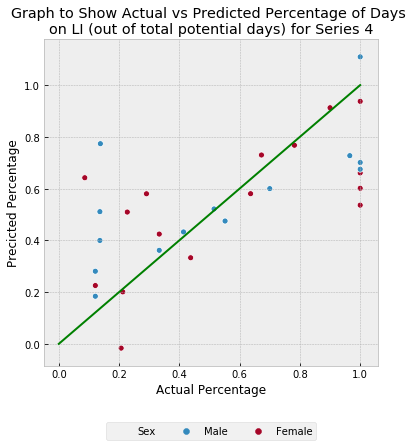

In [33]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
agg_df4["Sex"] = np.where(agg_df4["male"] == 1, "Male", "Female")

sns.scatterplot("n_days_perc", "pred", "Sex", data=agg_df4)
sns.lineplot([0,1], [0,1], color="green")

ax1.set(xlabel="Actual Percentage", ylabel="Precicted Percentage",
       title="Graph to Show Actual vs Predicted Percentage of Days \non LI (out of total potential days)\
 for Series 4")
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="center", ncol=4)

In [7]:
args = Arguments(5)

agg5 = AggAgg(args)
agg5.islander_agg().create_dummy().create_days()
agg_df5 = normalize(agg5.df)

agg_df5 = apply_mod(agg_df5, reg, poly)
agg_df5.head()

,islander,n_tweets,score,n_tweets_perc,favs,arrived,dumped,age,season,sex,col,white,male,n_days,n_days_perc,pred,diff,b_o_w
0,amber,203783,0.184032,0.298577,43.795624,1,59,21,5,female,#5D3BAC,0,0,58,1.000000,0.872380,0.127620,better
1,amy,111526,0.051014,0.209516,32.050478,1,37,26,5,female,#ED4F8A,1,0,36,0.620690,0.661046,-0.040356,worse
2,anna,130095,0.087269,0.157330,29.896591,1,52,29,5,female,#E4422D,0,0,51,0.879310,0.684519,0.194791,better
3,anton,76561,0.127779,0.144059,28.118196,1,56,24,5,male,#D7D5DC,1,1,55,0.948276,0.704081,0.244195,better
4,arabella,28742,0.015901,0.239962,44.191802,18,25,28,5,female,#F7F2F4,1,0,7,0.170732,0.568611,-0.397879,worse


### Testing
Given my aim is to predict the winner of Love Island 2019 I want to compare the two series and determine if using last years series as a training set is suitable. In light of this we can use the same model to predict the proportion of potential days an islander will stay in series 5, given the majority have already left we have a lot of validation sources and will be able to determine how good the fit is. 

Focusing on the R-squared term we actually see an increase - this is not expected but very good news! The similarity of the R-squared term suggests that the data is very similar which is encouraging for the second part of this work.

In [8]:
get_stats(agg_df5, reg, poly)

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: 0.19269711584811394 

Coefficient for x0: 4.283608063620655
Coefficient for x1: -0.09783586289138047
Coefficient for x0^2: -11.929859255408255
Coefficient for x0 x1: 9.663707948934706
Coefficient for x1^2: -1.4400753920217557

R^2 score: 0.5044522811916672


Plotting the relationship again we can see why as there are a number of points very close to the line (which represents a perfect correlation). 

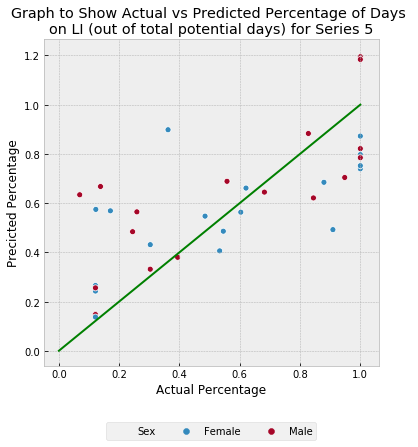

In [34]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

agg_df5["Sex"] = np.where(agg_df5["male"] == 1, "Male", "Female")

sns.scatterplot("n_days_perc", "pred", "Sex", data=agg_df5)
sns.lineplot([0,1], [0,1], color="green")

ax1.set(xlabel="Actual Percentage", ylabel="Precicted Percentage",
       title="Graph to Show Actual vs Predicted Percentage of Days \non LI (out of total potential days)\
 for Series 5")
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="center", ncol=4)

 In conclusion to this first part on predicting the number of potential days each individual islander lasts, we see that we can produce a fairly good model using the mean percentage of tweets than mention each islander per day combined with the mean sentiment score per day. We have seen that there is not a huge difference between series 4 and 5. To improve this model we could use more features about the individuals, such as sex, ethnicity and age for example, however I did this to compare the features we used to determine if we could use season 4 data to compare couples, which means we wouldn't be able to use these due to complexity and a very small sample size. 

### Predicting the Winner 

The second part of this work focuses around predicting the winner of Love Island 2019, instead of predicting number of days we shall be predicting the vote share, the training data can be found [here](https://www.itv.com/loveisland/news/your-love-island-2018-voting-results). Instead of doing this at an individual level we shall be aggregating by couple (including all the couples per vote) and instead of aggregating per day we shall be combining all the days between each vote as a grouping. The features we are going to use are the same as the first part (number of tweets and sentiment score). Given we are now focusing on couples, the fact that some islanders had the same name won't matter so much as we are focusing on tweets that explicitly reference both parties.

In [10]:
class PredCommon:
    def __init__(self, df):
        self.agg_df = pd.DataFrame()
        self.df = df
            
    def recode_col(self, sdate, edate, d_col):
        self.df["vote"] = np.where(
            (sdate <= self.df[d_col]) & (self.df[d_col] < edate), edate, self.df["vote"],
        )
        return self
    
    def recode_vote(self, d_col="date"):
        if self.args.season == 4:
            dl = ["2018-06-26", "2018-07-04", "2018-07-13", "2018-07-20", "2018-07-24", "2018-07-29"]
        else:
            dl = ["2019-06-26", "2019-07-07", "2019-07-12", "2019-07-19", "2019-07-23", "2019-07-29"]
        
        self.df["vote"] = np.where(self.df[d_col] < dl[0], dl[0], "else")
        for i in range(1, len(dl)-1):
            self.recode_col(dl[i], dl[i+1], d_col)
        return self
        
    def get_totals(self, gb=["vote"]):
        return self.do_agg(gb)[gb + ["n_tweets", "n_users"]].rename(
            columns={"n_tweets": "n_tweets_total", "n_users": "n_users_total"}
        )

    def get_perc(self, col):
        self.agg_df[col + "_perc"] = (
            self.agg_df[col] * 100 / self.agg_df[col + "_total"]
        )
        return self

In [11]:
class AggCouples(PredCommon):
    def __init__(self, args, df):
        PredCommon.__init__(self, df)
        self.args = args

        self.results = self.get_results()
        self.comb = self.get_couples(self.results)

        self.format_res()
        self.recode_vote()
        
    def get_results(self):
        if self.args.season == 4:
            return RESULTS_4
        else:
            return RESULTS_5

    @staticmethod
    def get_couples(results):
        comb = []
        [comb.extend(list(v.keys())) for k, v in results.items()]
        comb = list(set(comb))
        return comb

    def format_res(self):
        recode = {}
        for k0, v0 in self.results.items():
            recode[k0] = {}
            for k1, v1 in self.results[k0].items():
                recode[k0][k1[0] + "_" + k1[1]] = v1
        self.results = recode
        return self

    @staticmethod
    def format_pair(pair):
        pair = [i.lower() for i in pair]
        return pair, pair[0] + "_" + pair[1]

    def do_agg(self, gb=["vote"], ph=None):
        """Aggregate various metrics per couple/date"""
        AGG_JS = {
            "favs": "mean",
            "retwe": "mean",
            "score": "mean",
            "user": "nunique",
            "url": "count",
            "weight_senti": "mean",
        }
        RN_JS = {"url": "n_tweets", "user": "n_users"}
        df = self.df[self.df["score"] != 0]
        if ph is not None:
            df = df[df[ph] == ph]
            gb = gb + [ph]
            RN_JS[ph] = "couple"
        if len(df) > 0:
            return df.groupby(gb).agg(AGG_JS).reset_index().rename(columns=RN_JS)
        return pd.DataFrame()

    def get_agg_df(self):
        for pair in self.comb:
            pair, ph = self.format_pair(pair)
            if pair[0] in self.df.columns and pair[1] in self.df.columns:
                self.df[ph] = np.where(
                    (self.df[pair[0]] == pair[0]) & (self.df[pair[1]] == pair[1]),
                    ph,
                    "nan",
                )

                self.agg_df = self.agg_df.append(
                    self.do_agg(["vote"], ph), sort=True
                ).reset_index(drop=True)

        self.agg_df = self.agg_df.merge(self.get_totals(), on="vote", how="left")
        self.get_perc("n_tweets")
        self.get_perc("n_users")
        return self

    @staticmethod
    def get_split(x, n):
        return x.split("_")[n]

    def add_islanders(self):
        self.agg_df["female"] = self.agg_df["couple"].apply(
            lambda x: self.get_split(x, 0)
        )
        self.agg_df["male"] = self.agg_df["couple"].apply(
            lambda x: self.get_split(x, 1)
        )
        return self

    def get_res(self):
        res = pd.DataFrame.from_dict(self.results).reset_index()
        res = pd.melt(
            res, id_vars=["index"], value_vars=[c for c in res.columns if c != "index"]
        )
        res = res.rename(
            columns={"variable": "vote", "value": "v_share", "index": "couple"}
        )
        res["couple"] = res["couple"].str.lower()
        res["v_max"] = res.groupby(["couple", "vote"])["v_share"].transform(max)
        return (
            res[res["v_max"] == res["v_share"]]
            .drop(columns=["v_max"])
            .reset_index(drop=True)
        )

    def full_df(self):
        self.add_islanders()

        self.agg_df = self.agg_df.merge(
            self.get_res(), on=["vote", "couple"], how="left"
        )
        self.agg_df = self.agg_df[
            (self.agg_df["n_tweets_perc"].notna()) & 
            (self.agg_df["score"].notna()) & 
            (self.agg_df["v_share"].notna()
            )]
        return self


In [12]:
def get_btn(df):
    tmp = df[df["v_share"] != 1]
    tmp = tmp.groupby(["vote"])["v_share"].agg({"btm": 'count', "v_max":'max'}).reset_index()
    tmp["btm"] = tmp["btm"] / tmp["v_max"]
    return df.merge(tmp, on="vote", how="left")

def get_predictions(reg, df):
    df["pred_v_share"] = df.apply(
        lambda row:reg.predict(poly.fit_transform([[row["n_tweets_perc"], row["score"]]]))[0],
        axis=1
    )
    df["pred_order"] = df.sort_values(by="pred_v_share", ascending=False).groupby("vote").cumcount() + 1
    return get_btn(df)

def validate(df):
    df["rev_order_true"] = df.sort_values(by="v_share", ascending=True).groupby("vote").cumcount() + 1
    df["order_true"] = df.sort_values(by="v_share", ascending=False).groupby("vote").cumcount() + 1
    
    # df = df[df["rev_order_true"] <= 2]    
    cols = ["vote", "couple", 'n_tweets_perc', 'score', "v_share", "order_true","pred_v_share", "pred_order"]
    return df#[df["order_true"] != df["pred_order"]][cols].sort_values("vote").reset_index(drop=True)


def split_df(df, final="2019-07-29"):
    return df[df["vote"] != "2019-07-29"], df[df["vote"] == "2019-07-29"]
    
def find_accuracy(df):
    df["pos"] = df["pred_order"] / df["v_max"]
    
    df["true_bottom"] = np.where(df["v_share"] == 1.0, True, False)
    df["pred_bottom"] = np.where(df["pos"] > df["btm"], True, False)
    
    cols = ["vote", "couple", 'n_tweets_perc', 'score', "true_bottom", "pred_bottom", "pred_v_share", "pred_order"]
    return df[cols].sort_values("vote").reset_index(drop=True)


In [13]:
args = Arguments(4)

df = F.import_all(
    os.path.join(args.bucket, "season_" + str(args.season), "processed/")
)
fd4 = AggCouples(args, df)
fd4.get_agg_df().full_df()

In [14]:
agg_df_4 = normalize(fd4.agg_df, dep_col='v_share')
req, poly = fit_mod(agg_df_4, dep_col='v_share')

The results of the model look slightly different to the first part, here we see a positive linear relationship to both the number of tweets and sentiment score. We also see an intercept of very close to 0, this makes sense in this context as we are predicting the vote percentage and therefore one would expect a couple to have generated 0 activity online to get no votes in the real world. We see both of the non linear terms are negative, we have discussed why this could be earlier but also we know that the voting throughout this series was unprecedentedly in favour of Jack and Dani (they received over 50% of the vote at any given opportunity). We also see a negative R-squared score that doesn't fill us with much confidence moving forward!

In [15]:
get_stats(agg_df_4, reg, poly, dep_col="v_share")

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: 0.19269711584811394 

Coefficient for x0: 4.283608063620655
Coefficient for x1: -0.09783586289138047
Coefficient for x0^2: -11.929859255408255
Coefficient for x0 x1: 9.663707948934706
Coefficient for x1^2: -1.4400753920217557

R^2 score: -0.5635120945922423


Whilst we do care about the magnitude of the percentage vote received by each couple, what we really want to know is the relative order in which islanders are placed (whilst it's a popularity contest, to win you only need to have one more person like you over anyone else!). Looking at the accuracy of the model we again aren't filled with confidence; we see we only got the couple in the correct order in 43% of cases.

In [39]:
pred_df = get_predictions(req, agg_df_4)

for_scores = validate(pred_df)
print("Model Accuracy:", accuracy_score(for_scores["order_true"], for_scores["pred_order"]))
# validate(pred_df)

Model Accuracy: 0.43333333333333335


/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Looking at the graph we see a very positive relationship, we do however see that the model will be very influenced by the couples with a very high percentage of votes (above 50%) even though this isn't relevant to the majority of points. By just eyeballing this graph one might suggest the model looks good, however there is a lot of variation between the actual vote share and the predicted scores, which is starting to suggest that the features we have chosen are not valuable for this part as they were for part 1. The fact we have a negative R-squared term is suggesting that the points with a very high vote share having such a large influence over the model that they are negatively impacting the results from all other points.

/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


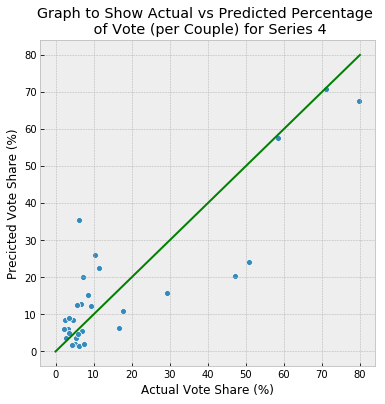

In [47]:
pred_df = get_predictions(req, agg_df_4)
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

sns.scatterplot("v_share", "pred_v_share", data=pred_df)
sns.lineplot([0,80], [0,80], color="green")

ax1.set(xlabel="Actual Vote Share (%)", ylabel="Precicted Vote Share (%)",
       title="Graph to Show Actual vs Predicted Percentage \n of Vote (per Couple) for Series 4");

In [18]:
args = Arguments(5)

df = F.import_all(
    os.path.join(args.bucket, "season_" + str(args.season), "processed/")
)
fd5 = AggCouples(args, df)
fd5.get_agg_df().full_df()

Applying the model to series 5 we see a really bad R-squared score, we would expect this score to decrease however confidence is at an all time low in this model working for series 5!

In [19]:
agg_df_5 = normalize(fd5.agg_df, dep_col='v_share')
get_stats(agg_df_5, reg, poly, dep_col="v_share")

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: 0.19269711584811394 

Coefficient for x0: 4.283608063620655
Coefficient for x1: -0.09783586289138047
Coefficient for x0^2: -11.929859255408255
Coefficient for x0 x1: 9.663707948934706
Coefficient for x1^2: -1.4400753920217557

R^2 score: -2.139177031651563


We have no validation data for series 5 as ITV haven't released the vote spilts yet, what we do know is which couples were in the bottom two or three every time the public voted, ordering based on our predicted percentages and then comparing this with the order that was revealed on the show (ie were they in the couples at risk of being dumped or safe), we see that we got this wrong 9 times out of 36. Given the room for error is now so much more this might be masking the fact that the model doesn't fit well.

From this table we can see that there are a number of votes / couples that can be explained as are slightly a-typical, given we are basing this on Series 4 there was no couple that was unanimously disliked for the length of time that Anna and Jordan were; they are generated so many tweets that even the model with the negative squared term for this feature could predict this correctly! We see that the n_tweets_perc variable for 23rd July is over double the second largest in this data frame, given this is a normalized column this shows the extent at which people tweeted about them. Other examples that can be explained are Molly and Tommy, the public perception was that Molly didn't like Tommy and therefore tweets that mention the couple have a lower score than the popularity of them would suggest it should so the model is not great here.

In [20]:
pred_df = get_predictions(req, agg_df_5)
pred_df, final_df = split_df(pred_df)
pred_df = find_accuracy(pred_df)

print("Model Accuracy:", accuracy_score(pred_df["true_bottom"], pred_df["pred_bottom"]))
pred_df[pred_df["pred_bottom"] != pred_df["true_bottom"]]

Model Accuracy: 0.6296296296296297


/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,vote,couple,n_tweets_perc,score,true_bottom,pred_bottom,pred_v_share,pred_order
3,2019-06-26,maura_tom,0.067344,-0.002573,True,False,6.490263,2
6,2019-06-26,molly_tommy,0.141843,0.053339,False,True,1.091925,7
11,2019-07-12,belle_anton,0.056094,0.129684,False,True,3.835828,6
13,2019-07-12,michael_joanna,0.162483,-0.051027,True,False,5.444483,4
15,2019-07-19,belle_anton,0.156492,-0.008484,False,True,2.537478,5
17,2019-07-19,michael_francesca,0.004384,0.220109,True,False,12.177530,2
18,2019-07-19,molly_tommy,0.126299,0.100473,False,True,2.015687,6
19,2019-07-19,anna_jordan,0.077808,0.046095,True,False,2.708437,4
23,2019-07-23,anna_jordan,0.281446,0.044046,True,False,11.058023,4
26,2019-07-23,molly_tommy,0.124610,0.161529,False,True,6.480879,6


Finally, what everyone is really reading this for...predicting the winner! We only went and got it right!! We did however get the 2nd and 3rd place the wrong way round. When interpreting these results is important to remember that the predicted vote share is not capped and therefore the total can (and clearly does here) add up to more than 100%, give its relative we see that Amber and Greg have over double the predicted share as the next largest and given what we know about the model coefficients this suggest a huge number of very positive tweets in comparison to the other couples. 

In [51]:
# final_df["pred_perc"] = final_df["pred_v_share"]*100 / final_df["pred_v_share"].sum()

final_df[["couple", 'n_tweets_perc', 'score', "pred_v_share", "pred_order"]].sort_values("pred_order")

,couple,n_tweets_perc,score,pred_v_share,pred_order
7,amber_greg,0.272959,0.387364,89.716452,1
19,india_ovie,0.267766,0.243724,40.749755,2
30,molly_tommy,0.243338,0.224422,30.994138,3
22,maura_curtis,0.385357,0.031927,29.279050,4
